# Trabajo Práctico 3 - Computer Vision


In [15]:
import os
import numpy as np
import pandas as pd
import requests
import io
import seaborn as sns
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Activation, Dense, Input, Dropout, MaxPooling2D, Flatten 
from keras.preprocessing.image import ImageDataGenerator, load_img
from IPython.display import HTML, display
%matplotlib inline

### Configuraciones generales

In [16]:
size = 70
path='UCSE-ML-Moreno-Rodriguez-Sorati-master/data/img_align_celeba/img_align_celeba'
#path='imagenes_tp3_cv'

In [17]:
data= pd.read_csv('UCSE-ML-Moreno-Rodriguez-Sorati-master/data/list_attr_celeba.csv',usecols=['image_id','Smiling'])
data_partition=pd.read_csv('UCSE-ML-Moreno-Rodriguez-Sorati-master/data/list_eval_partition.csv',usecols=['image_id','partition'])

data['Smiling']=data['Smiling'].replace([1], 'Si')
data['Smiling']=data['Smiling'].replace([-1], 'No')


### Visualizamos algunas de las imágenes del dataset

'Si'

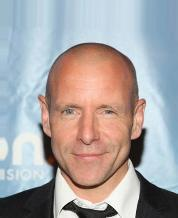

'No'

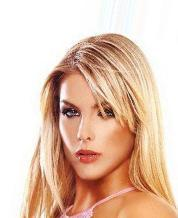

'No'

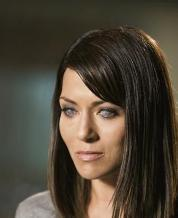

'Si'

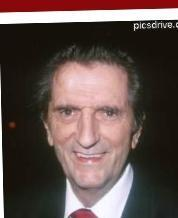

'Si'

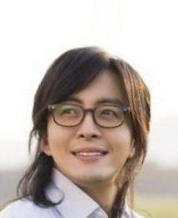

In [18]:
ids_img = data.sample(5)

for i in range(0, len(ids_img)):   
    image=load_img(os.path.join(path, ids_img.iloc[i]['image_id']))
    display(ids_img.iloc[i]['Smiling'])
    display(image)

### Construimos los dataframes de Train, Test y Validation

In [19]:
df_merge = pd.merge(data, data_partition, how='inner', on = 'image_id')

In [20]:
train=df_merge[df_merge['partition']==0]
test=df_merge[df_merge['partition']==1]
validation=df_merge[df_merge['partition']==2]

train=train.drop(['partition'],axis=1)
test=test.drop(['partition'],axis=1)
validation=validation.drop(['partition'],axis=1)

## Volumetría de datos

0    162770
2     19962
1     19867
Name: partition, dtype: int64

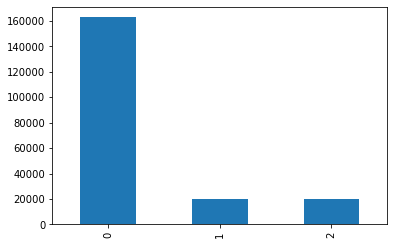

In [21]:
df_merge['partition'].value_counts().sort_index().plot.bar(x = 'x')
df_merge['partition'].value_counts()

## Balanceo en Train,Test y Validation

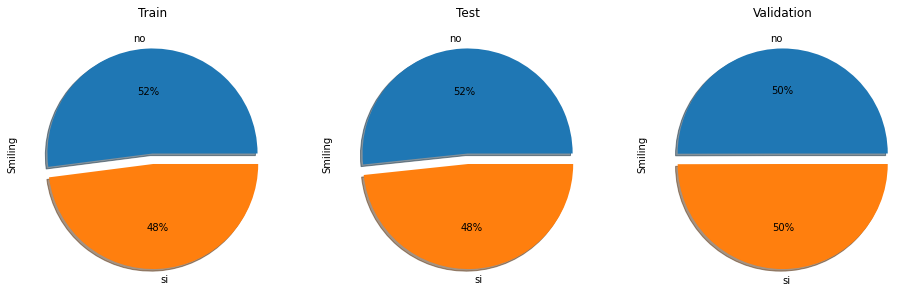

In [22]:
f,ax=plt.subplots(1,3,figsize=(16,6))

ax[0].set_title('Train')
train["Smiling"].value_counts().plot.pie(labels = ["no","si"],
                                              autopct = "%1.0f%%",
                                              shadow = True,explode=[0,.1],
                                              ax=ax[0],)
ax[1].set_title('Test')
test["Smiling"].value_counts().plot.pie(labels = ["no","si"],
                                              autopct = "%1.0f%%",
                                              shadow = True,explode=[0,.1],
                                              ax=ax[1],)
ax[2].set_title('Validation')
validation["Smiling"].value_counts().plot.pie(labels = ["no","si"],
                                              autopct = "%1.0f%%",
                                              shadow = True,explode=[0,.1],
                                              ax=ax[2],)

## Generador de datos de imágenes

In [23]:
datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=path,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=True,
    seed=42,
    target_size=(70, 70)
)

val_generator = datagen.flow_from_dataframe(
    dataframe=validation,
    directory=path,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70, 70)
)


test_generator= datagen.flow_from_dataframe(
    dataframe=test,
    directory=path,
    x_col='image_id',
    y_col='Smiling',
    class_mode="binary",
    batch_size=32,
    shuffle=False,
    seed=42,
    target_size=(70, 70)
)

Found 162770 validated image filenames belonging to 2 classes.
Found 19962 validated image filenames belonging to 2 classes.
Found 19867 validated image filenames belonging to 2 classes.


### Función para predecir

In [24]:
def prediccion(model,sets):
    global ctrue 
    global cfalse 
    
    ctrue = 0
    cfalse = 0
    class_names=['NO','SI']
    sets.reset()
    image_batch, classes_batch = next(sets)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
        image = image_batch[k]
        pred = predicted_batch[k]
        the_pred=int(round(pred[0]))
        predicted = class_names[the_pred]
        val_pred = max(pred)
        the_class=int(classes_batch[k])
        value = class_names[the_class]
        plt.figure(k)
        isTrue = (the_pred == the_class)
        
        if isTrue:
            
            ctrue = ctrue + 1      
            
        else:
            
            cfalse = cfalse + 1
            
        plt.title(str(isTrue) + '  - Sonrie:  ' + str(value) + '  -  ' + ' Predicción:  ' + str(predicted)+'  Porcentaje de confianza:  ' + '[' + str(val_pred) + ']')

        plt.imshow(image)
    
    print('Predicciones Correctas: ' + str(ctrue))
    print('Predicciones Incorrectas: ' + str(cfalse))

## Convolutional Neural Network 1

In [12]:
cnn_model_1 = Sequential()

cnn_model_1.add(Conv2D(32, (3, 3), padding='same', input_shape=(70, 70, 3), activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
cnn_model_1.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_1.add(Dropout(0.25))

cnn_model_1.add(Flatten())
cnn_model_1.add(Dense(512, activation='relu'))
cnn_model_1.add(Dropout(0.5))

cnn_model_1.add(Dense(1, activation='sigmoid')) #Probar

In [ ]:
#Configuración de optimización

#Para softmax
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

#Para sigmoide
cnn_model_1.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [13]:
train_generator.reset()
test_generator.reset()
history=cnn_model_1.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 1475s 290ms/step - loss: 0.3971 - accuracy: 0.8028 - val_loss: 0.1996 - val_accuracy: 0.9048
Epoch 2/6
5087/5087 [==============================] - 1445s 284ms/step - loss: 0.2605 - accuracy: 0.8910 - val_loss: 0.2008 - val_accuracy: 0.9098
Epoch 3/6
5087/5087 [==============================] - 1447s 285ms/step - loss: 0.2447 - accuracy: 0.8974 - val_loss: 0.2210 - val_accuracy: 0.9129
Epoch 4/6
5087/5087 [==============================] - 1452s 285ms/step - loss: 0.2367 - accuracy: 0.9018 - val_loss: 0.1652 - val_accuracy: 0.9129
Epoch 5/6
5087/5087 [==============================] - 1449s 285ms/step - loss: 0.2335 - accuracy: 0.9031 - val_loss: 0.1927 - val_accuracy: 0.9149
Epoch 6/6
5087/5087 [==============================] - 1447s 284ms/step - loss: 0.2306 - accuracy: 0.9032 - val_loss: 0.1941 - val_accuracy: 0.9152


In [ ]:
#Guardamos el modelo, para no tener que reentrenar
cnn_model_1.save('cnn_model_1.h5')

In [26]:
# Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
cnn_model_1 = load_model('cnn_model_2.h5')

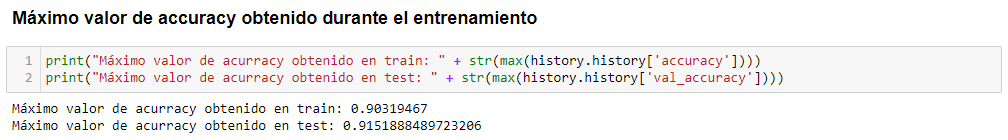

## Convolutional Neural Network 2

In [15]:
cnn_model_2 = Sequential()

cnn_model_2.add(Conv2D(16, (3, 3), padding='same', input_shape=(70, 70, 3), activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Conv2D(128, (10, 10), padding='same', activation='relu'))
cnn_model_2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_2.add(Dropout(0.25))

cnn_model_2.add(Flatten())
cnn_model_2.add(Dense(1024, activation='relu'))
cnn_model_2.add(Dropout(0.5))

cnn_model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

cnn_model_2.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [16]:
train_generator.reset()
val_generator.reset()
history_cnn_model_2=cnn_model_2.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 2262s 445ms/step - loss: 0.3672 - accuracy: 0.8212 - val_loss: 0.1896 - val_accuracy: 0.9032
Epoch 2/6
5087/5087 [==============================] - 2323s 457ms/step - loss: 0.2476 - accuracy: 0.8951 - val_loss: 0.2430 - val_accuracy: 0.9115
Epoch 3/6
5087/5087 [==============================] - 2247s 442ms/step - loss: 0.2322 - accuracy: 0.9018 - val_loss: 0.2527 - val_accuracy: 0.9134
Epoch 4/6
5087/5087 [==============================] - 2278s 448ms/step - loss: 0.2267 - accuracy: 0.9050 - val_loss: 0.1961 - val_accuracy: 0.9137
Epoch 5/6
5087/5087 [==============================] - 2330s 458ms/step - loss: 0.2217 - accuracy: 0.9069 - val_loss: 0.2138 - val_accuracy: 0.9175
Epoch 6/6
5087/5087 [==============================] - 2345s 461ms/step - loss: 0.2185 - accuracy: 0.9090 - val_loss: 0.2039 - val_accuracy: 0.9165


In [25]:
#Guardamos el modelo, para no tener que reentrenar
cnn_model_2.save('cnn_model_2.h5')

In [27]:
# Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
cnn_model_2 = load_model('cnn_model_3.h5')

### Máximo valor de accuracy obtenido durante el entrenamiento

In [18]:
print("Máximo valor de accuracy obtenido en train: " + str(max(history_cnn_model_2.history['accuracy'])))
print("Máximo valor de accuracy obtenido en test: " + str(max(history_cnn_model_2.history['val_accuracy'])))

Máximo valor de acurracy obtenido en train: 0.90904343
Máximo valor de acurracy obtenido en test: 0.917543351650238


### Probamos ahora quitando el parametro padding ya que consideramos que la informacion mas importante a predecir en la imagen se encuentra ubicada en el centro de la misma

## Convolutional Neural Network 3

In [14]:
cnn_model_3 = Sequential()

cnn_model_3.add(Conv2D(32, (3, 3), input_shape=(70, 70, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_3.add(Dropout(0.25))

cnn_model_3.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_3.add(Dropout(0.25))

cnn_model_3.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_3.add(Dropout(0.25))

cnn_model_3.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model_3.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_3.add(Dropout(0.25))

cnn_model_3.add(Flatten())
cnn_model_3.add(Dense(512, activation='relu'))
cnn_model_3.add(Dropout(0.5))

cnn_model_3.add(Dense(1, activation='sigmoid'))

In [15]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

cnn_model_3.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [16]:
train_generator.reset()
test_generator.reset()
history_cnn_model_3=cnn_model_3.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 1188s 233ms/step - loss: 0.4607 - accuracy: 0.7588 - val_loss: 0.2155 - val_accuracy: 0.8977
Epoch 2/6
5087/5087 [==============================] - 1076s 211ms/step - loss: 0.2766 - accuracy: 0.8843 - val_loss: 0.2348 - val_accuracy: 0.9064
Epoch 3/6
5087/5087 [==============================] - 1059s 208ms/step - loss: 0.2528 - accuracy: 0.8949 - val_loss: 0.2385 - val_accuracy: 0.9095
Epoch 4/6
5087/5087 [==============================] - 1057s 208ms/step - loss: 0.2439 - accuracy: 0.8992 - val_loss: 0.2618 - val_accuracy: 0.9078
Epoch 5/6
5087/5087 [==============================] - 1059s 208ms/step - loss: 0.2379 - accuracy: 0.9014 - val_loss: 0.2317 - val_accuracy: 0.9151
Epoch 6/6
5087/5087 [==============================] - 1058s 208ms/step - loss: 0.2356 - accuracy: 0.9023 - val_loss: 0.2336 - val_accuracy: 0.9160


In [17]:
#Guardamos el modelo, para no tener que reentrenar
cnn_model_3.save('cnn_model_3_sinPadding.h5')

In [28]:
# Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
cnn_model_3 = load_model('cnn_model_3_sinPadding.h5')

### Máximo valor de accuracy obtenido durante el entrenamiento


#### Máximo valor de accuracy obtenido en train: 0.9023
#### Máximo valor de accuracy obtenido en test: 0.9160

## Convolutional Neural Network 4

In [21]:
cnn_model_4 = Sequential()

cnn_model_4.add(Conv2D(16, (3, 3), input_shape=(70, 70, 3), activation='relu'))
cnn_model_4.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_4.add(Dropout(0.25))

cnn_model_4.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model_4.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_4.add(Dropout(0.25))

cnn_model_4.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model_4.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model_4.add(Dropout(0.25))

cnn_model_4.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model_4.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model_4.add(Dropout(0.25))

cnn_model_4.add(Flatten())
cnn_model_4.add(Dense(1024, activation='relu'))
cnn_model_4.add(Dropout(0.5))

cnn_model_4.add(Dense(1, activation='sigmoid'))

In [22]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)

cnn_model_4.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [23]:
train_generator.reset()
val_generator.reset()
history_cnn_model_4=cnn_model_4.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 955s 188ms/step - loss: 0.4290 - accuracy: 0.7796 - val_loss: 0.2601 - val_accuracy: 0.9014
Epoch 2/6
5087/5087 [==============================] - 930s 183ms/step - loss: 0.2606 - accuracy: 0.8912 - val_loss: 0.1951 - val_accuracy: 0.9096
Epoch 3/6
5087/5087 [==============================] - 937s 184ms/step - loss: 0.2448 - accuracy: 0.8986 - val_loss: 0.2386 - val_accuracy: 0.9136
Epoch 4/6
5087/5087 [==============================] - 982s 193ms/step - loss: 0.2356 - accuracy: 0.9020 - val_loss: 0.2235 - val_accuracy: 0.9141
Epoch 5/6
5087/5087 [==============================] - 957s 188ms/step - loss: 0.2304 - accuracy: 0.9041 - val_loss: 0.2080 - val_accuracy: 0.9131
Epoch 6/6
5087/5087 [==============================] - 979s 193ms/step - loss: 0.2278 - accuracy: 0.9049 - val_loss: 0.2222 - val_accuracy: 0.9156


In [25]:
#Guardamos el modelo, para no tener que reentrenar
cnn_model_4.save('cnn_model_4_sinPadding.h5')

In [29]:
# Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
cnn_model_4 = load_model('cnn_model_4_sinPadding.h5')

### Máximo valor de accuracy obtenido durante el entrenamiento


#### Máximo valor de accuracy obtenido en train: 0.9049
#### Máximo valor de accuracy obtenido en test: 0.9156

### Se observa que el modelo que mejor accuracy dio fue el 2do, con un valor 0.9069 en train y 0.9165 en test, sin embargo notamos que el tiempo de entrenamiento fue excesivo considerando que el 3er modelo, con un valor 0.9023 en train y 0.9160 en test, dio un accuracy levemente inferior en la mitad de tiempo.

### Curva de aprendizaje del modelo CNN 3: train vs test

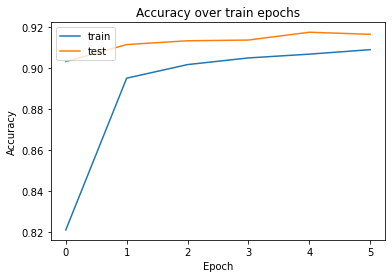

In [17]:
plt.plot(history_cnn_model_3.history['accuracy'], label='train')
plt.plot(history_cnn_model_3.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Evaluamos el modelo elegido con el dataset de Test:

In [33]:
cnn_model_3.evaluate_generator(test_generator)

[0.2687833607196808, 0.9201691150665283]

### Testeamos el modelo CNN 3 con un nuevo conjunto de imagenes

c:\users\gasto\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Predicciones Correctas: 25
Predicciones Incorrectas: 7


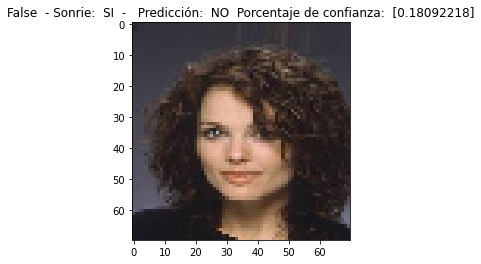

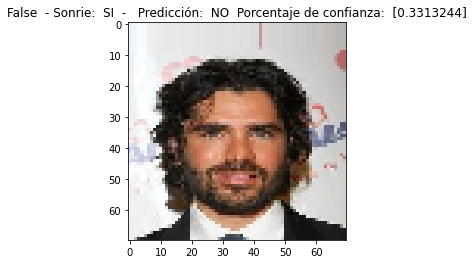

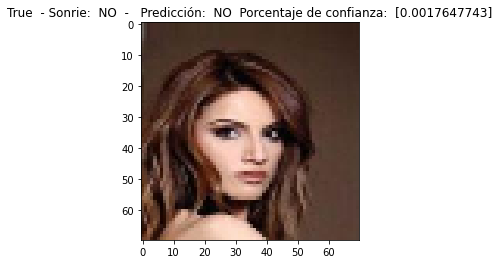

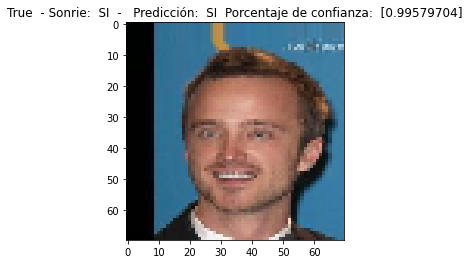

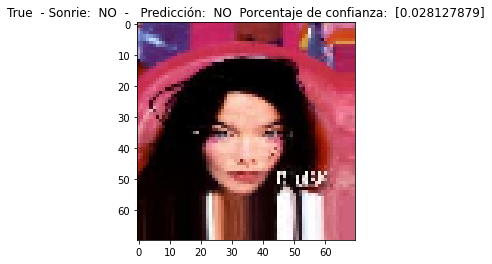

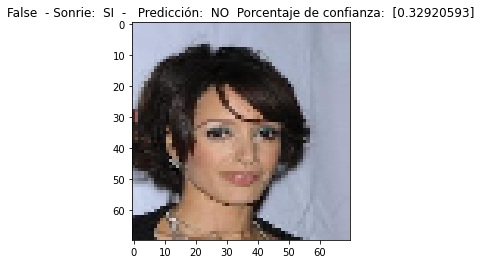

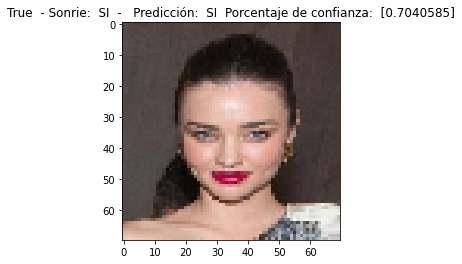

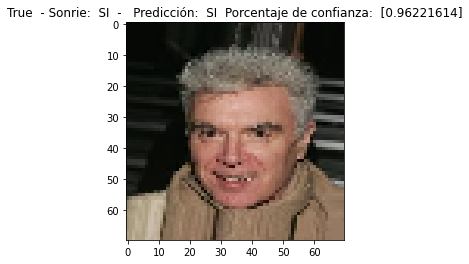

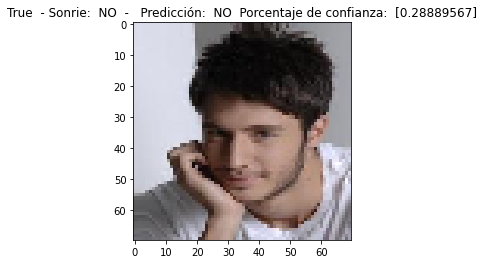

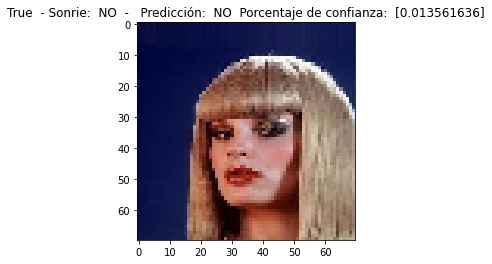

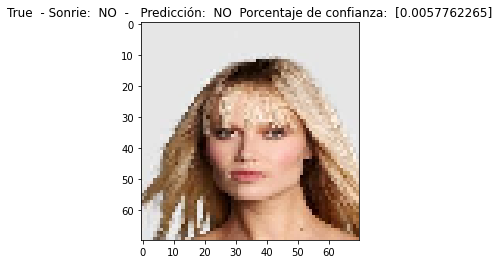

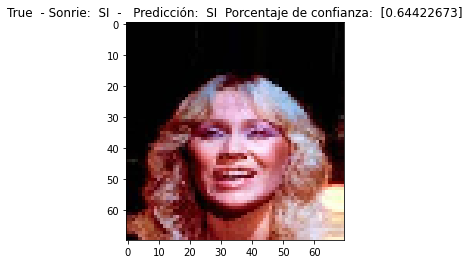

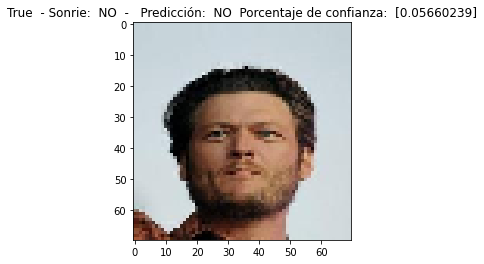

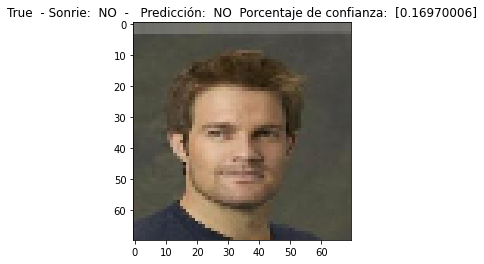

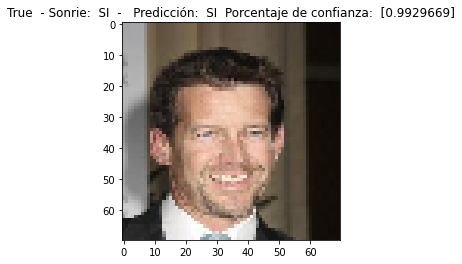

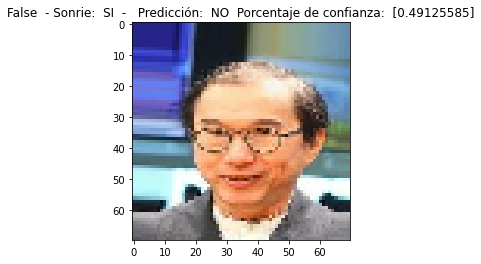

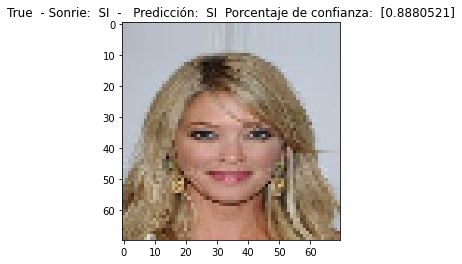

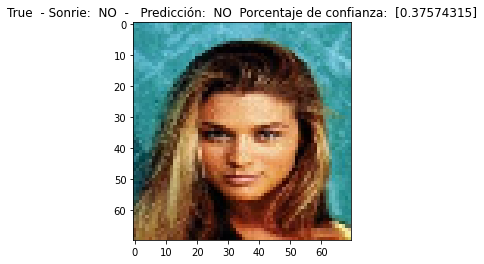

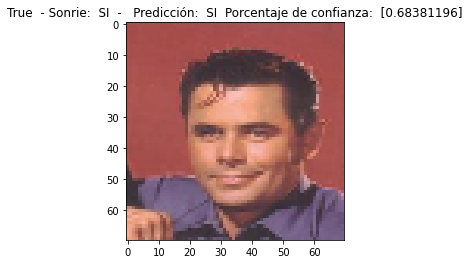

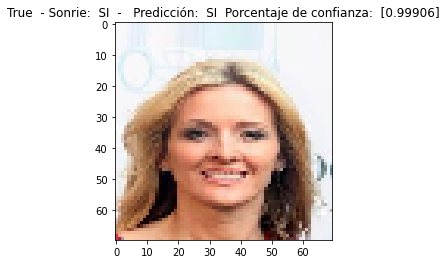

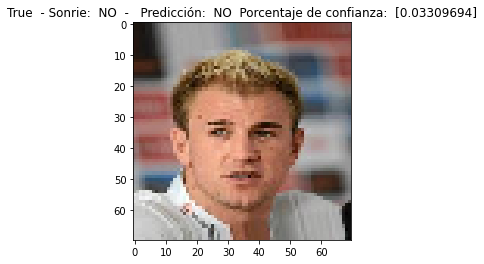

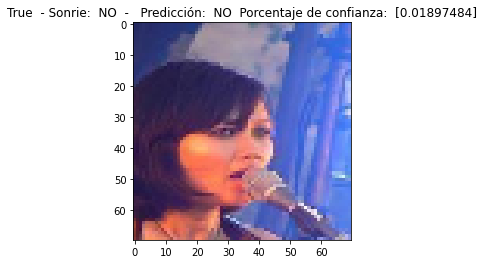

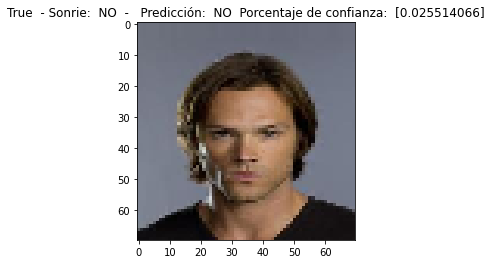

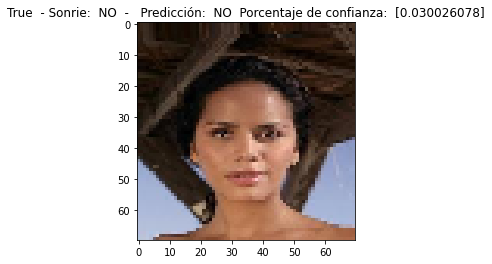

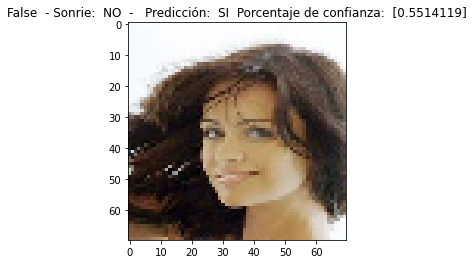

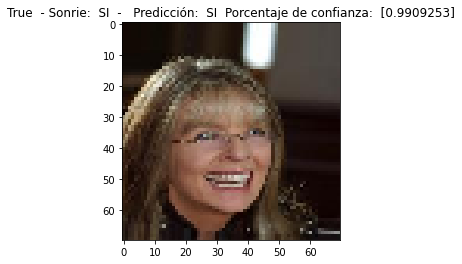

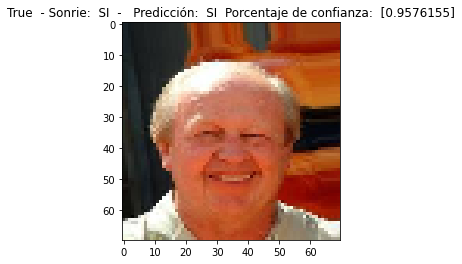

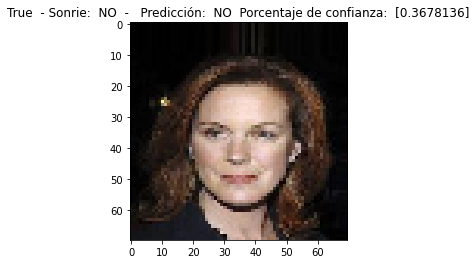

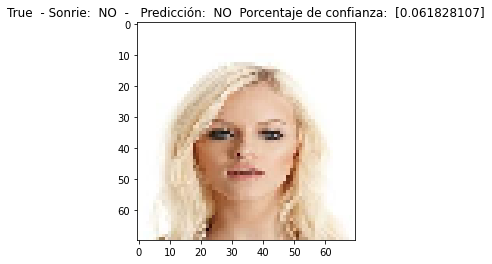

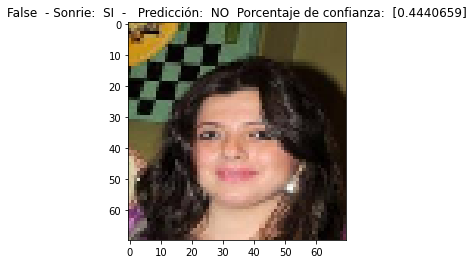

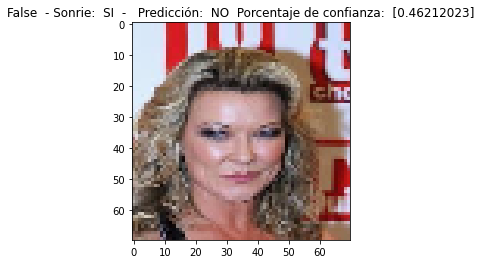

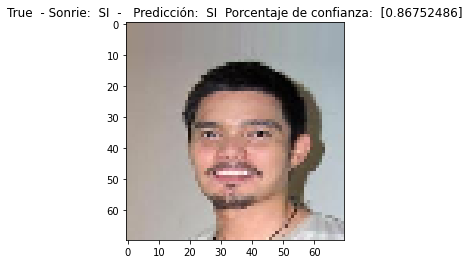

In [37]:
prediccion(cnn_model_3,test_generator)

### Conclusiones Convolutional Neural Network
Los resultados obtenidos a partir de la métrica accuracy son muy buenos observamos valores de accuracy en train de 0.9023 y en test de 0.9160.

Al observar los resultados se espera que el modelo sea capaz de predicir correctamente si una persona está sonriendo o no. Para ello, utilizamos imágenes de nuestro dataset como ejemplo, y se las dimo como inputs al modelo entrenado, para que este determine si la persona que se encuentra en dicha imagen está o no sonriendo.  Los resultados de este entrenamiento concluyeron con éxito, ya que, el modelo fue capaz de predecir las imágenes según lo esperado.

Podemos concluir que el modelo es confiable y capaz de predecir correctamente.

## MLP Neural Network 1

In [23]:
mlp_model_1 = Sequential([   Flatten(input_shape=(70,70,3)),
    Dense(500),
    Activation('relu'),
    Dropout(0.10),
    Dense(250),
    Activation('relu'),
    Dropout(0.10),
    Dense(125),
    Activation('relu'),
    Dropout(0.10),
    Dense(60),
    Activation('relu'),
    Dropout(0.10),
    Dense(30),
    Activation('relu'),
    Dropout(0.10),
    Dense(1),
    Activation('sigmoid'),
])


In [ ]:
mlp_model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [24]:
train_generator.reset()
val_generator.reset()
history_mlp = mlp_model_1.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 1164s 229ms/step - loss: 0.4157 - accuracy: 0.7887 - val_loss: 0.2252 - val_accuracy: 0.8863
Epoch 2/6
5087/5087 [==============================] - 1135s 223ms/step - loss: 0.3440 - accuracy: 0.8355 - val_loss: 0.1919 - val_accuracy: 0.8873
Epoch 3/6
5087/5087 [==============================] - 1183s 233ms/step - loss: 0.3427 - accuracy: 0.8413 - val_loss: 0.2092 - val_accuracy: 0.8789
Epoch 4/6
5087/5087 [==============================] - 1133s 223ms/step - loss: 0.3622 - accuracy: 0.8368 - val_loss: 0.3524 - val_accuracy: 0.8349
Epoch 5/6
5087/5087 [==============================] - 1120s 220ms/step - loss: 0.3469 - accuracy: 0.8421 - val_loss: 0.2275 - val_accuracy: 0.8930
Epoch 6/6
5087/5087 [==============================] - 1107s 218ms/step - loss: 0.3150 - accuracy: 0.8542 - val_loss: 0.1867 - val_accuracy: 0.8910


In [ ]:
#Guardamos el modelo, para no tener que reentrenar
mlp_model_1.save('mlp_model_1.h5')

In [ ]:
#Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
mlp_model_1 = load_model('mlp_model_1.h5')

### Máximo valor de accuracy obtenido durante el entrenamiento


#### Máximo valor de accuracy obtenido en train: 0.8542
#### Máximo valor de accuracy obtenido en test: 0.8930

## MLP Neural Network 2

In [15]:
mlp_model_2 = Sequential([   Flatten(input_shape=(70,70,3)),
    Dense(1000, ),
    Activation('relu'),
    Dense(500),
    Activation('relu'),
    Dropout(0.10),
    Dense(250),
    Activation('relu'),
    Dropout(0.10),
    Dense(125),
    Activation('relu'),
    Dropout(0.10),
    Dense(60),
    Activation('relu'),
    Dropout(0.10),
    Dense(30),
    Activation('relu'),
    Dropout(0.10),
    Dense(1),
    Activation('sigmoid'),
])

In [ ]:
mlp_model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [16]:
history_mlp = mlp_model_2.fit(train_generator, epochs=6, workers=4, validation_data=val_generator)

Epoch 1/6
5087/5087 [==============================] - 2022s 397ms/step - loss: 0.3762 - accuracy: 0.8248 - val_loss: 0.2379 - val_accuracy: 0.8857
Epoch 2/6
5087/5087 [==============================] - 2017s 397ms/step - loss: 0.2895 - accuracy: 0.8797 - val_loss: 0.2139 - val_accuracy: 0.8905
Epoch 3/6
5087/5087 [==============================] - 2016s 396ms/step - loss: 0.2760 - accuracy: 0.8845 - val_loss: 0.2683 - val_accuracy: 0.8741
Epoch 4/6
5087/5087 [==============================] - 2018s 397ms/step - loss: 0.2716 - accuracy: 0.8867 - val_loss: 0.2636 - val_accuracy: 0.8836
Epoch 5/6
5087/5087 [==============================] - 2019s 397ms/step - loss: 0.2648 - accuracy: 0.8903 - val_loss: 0.2364 - val_accuracy: 0.8966
Epoch 6/6
5087/5087 [==============================] - 2016s 396ms/step - loss: 0.2614 - accuracy: 0.8924 - val_loss: 0.2227 - val_accuracy: 0.8987


In [25]:
#Guardamos el modelo, para no tener que reentrenar
mlp_model_2.save('mlp_model_2.h5')

In [41]:
#Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
mlp_model_2 = load_model('mlp_model_2.h5')

### Máximo valor de accuracy obtenido durante el entrenamiento

In [21]:
print("Máximo valor de accuracy obtenido en train: " + str(max(history_mlp_2.history['accuracy'])))
print("Máximo valor de accuracy obtenido en test: " + str(max(history_mlp_2.history['val_accuracy'])))

Máximo valor de acurracy obtenido en train: 0.89237577
Máximo valor de acurracy obtenido en test: 0.8987075686454773


### Se observa que pese a que el 1er modelo entrenado tiene un tiempo de entrenamiento menor, se opto por elegir el 2do modelo ya que presentó un accuracy mayor.

### Curva de aprendizaje del modelo MLP 2: train vs test


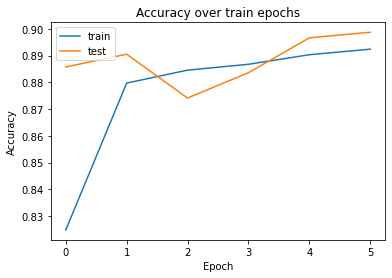

In [19]:
plt.plot(history_mlp_2.history['accuracy'], label='train')
plt.plot(history_mlp_2.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Evaluamos el modelo elegido con el dataset de Test:

In [253]:
mlp_model_2.evaluate_generator(test_generator)

[0.2535950541496277, 0.9019479751586914]

### Testeamos el modelo MLP 2 con un nuevo conjunto de imagenes

c:\users\gasto\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Predicciones Correctas: 25
Predicciones Incorrectas: 7


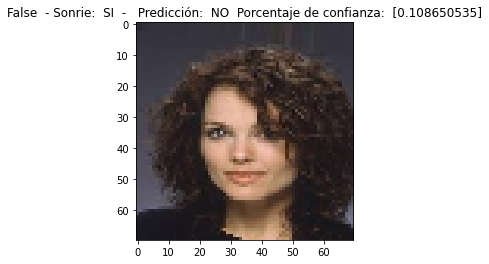

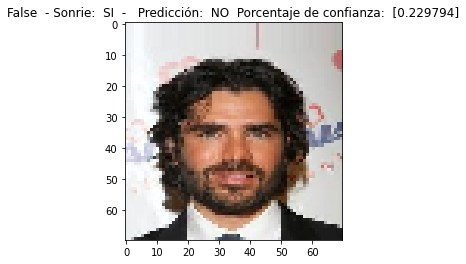

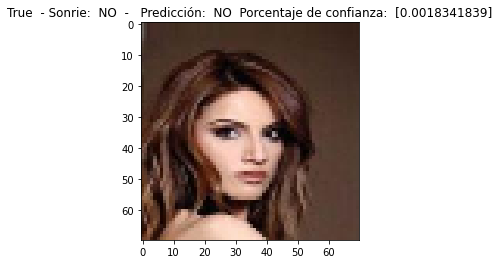

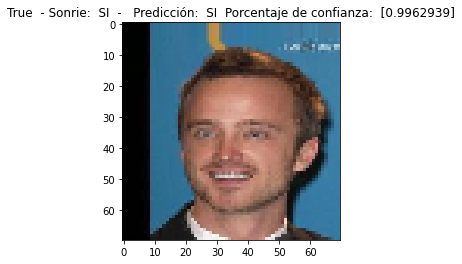

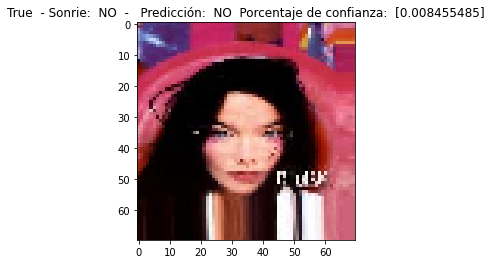

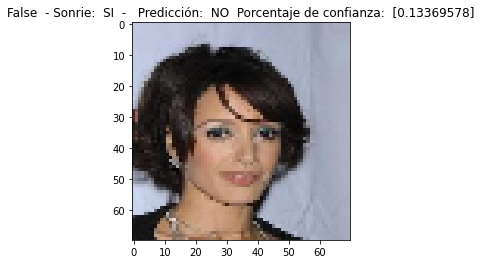

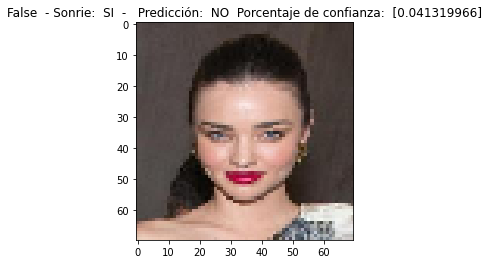

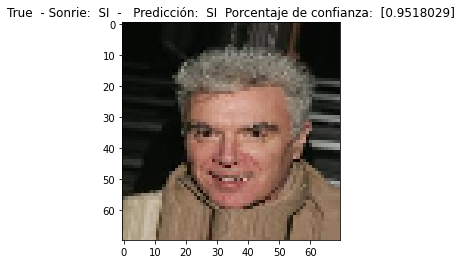

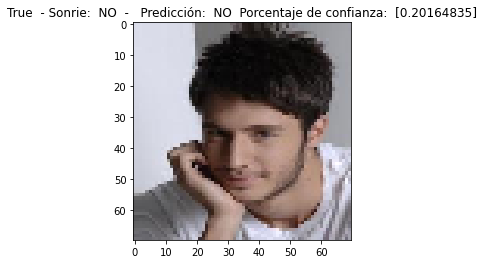

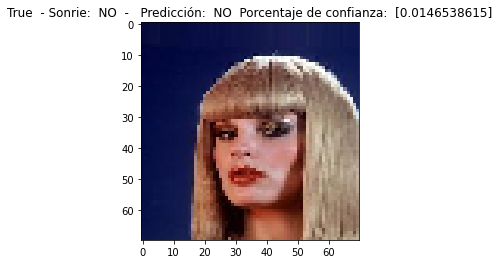

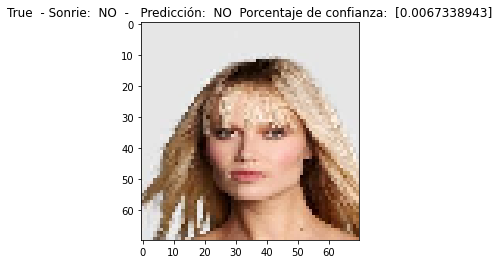

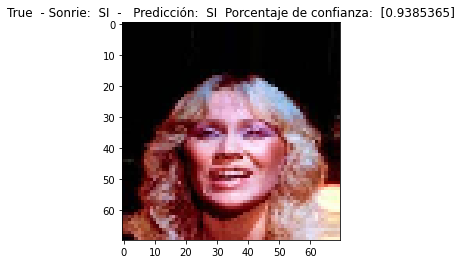

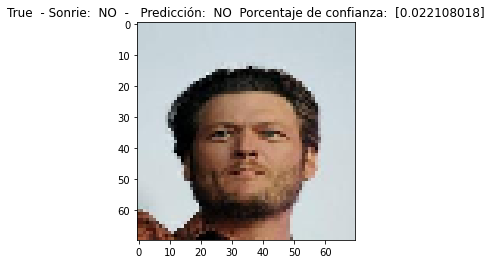

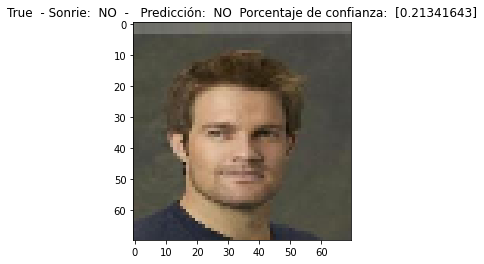

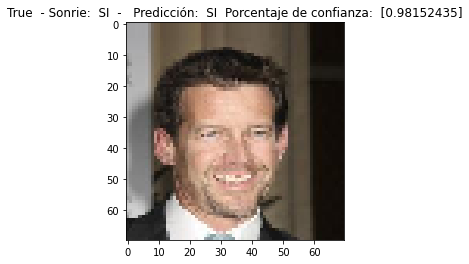

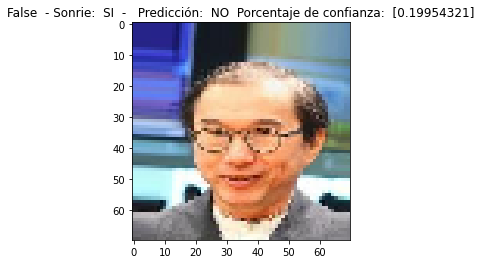

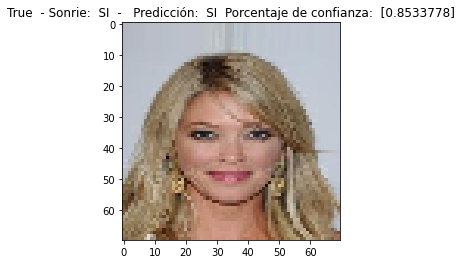

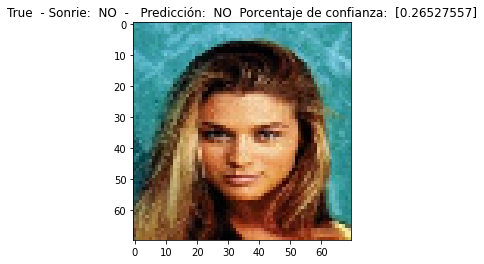

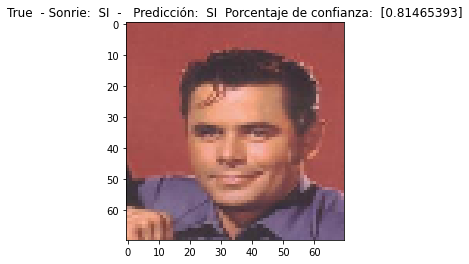

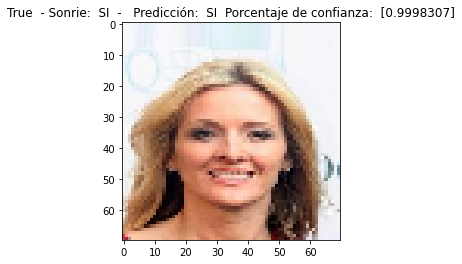

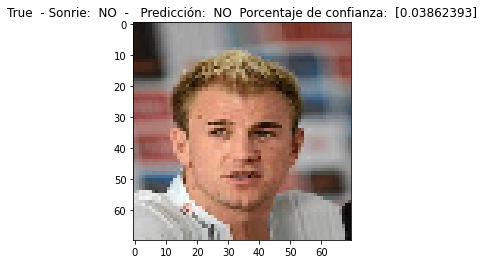

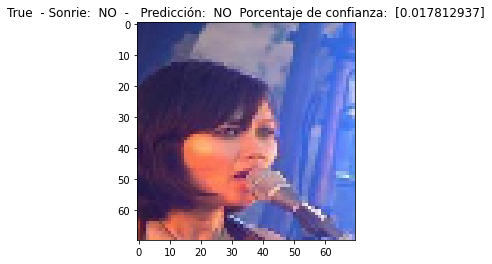

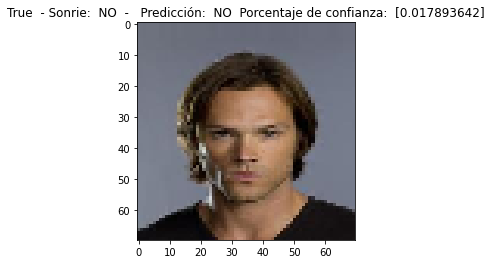

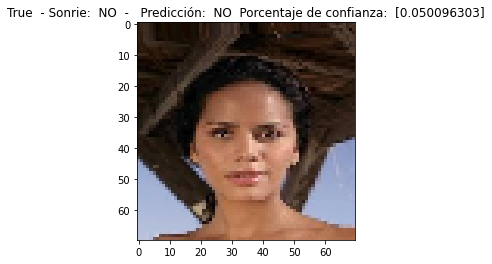

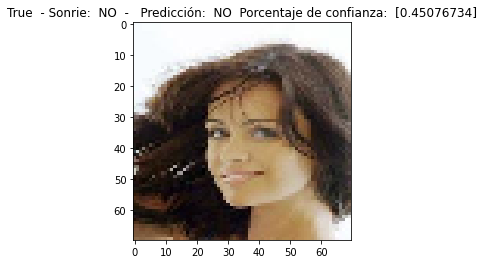

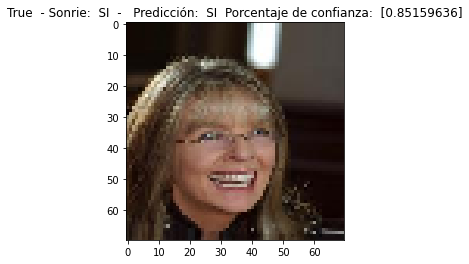

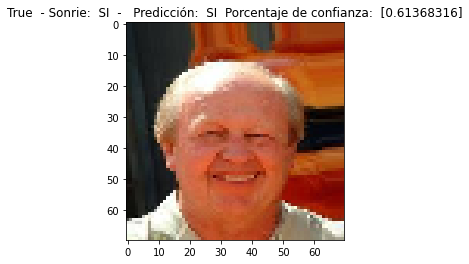

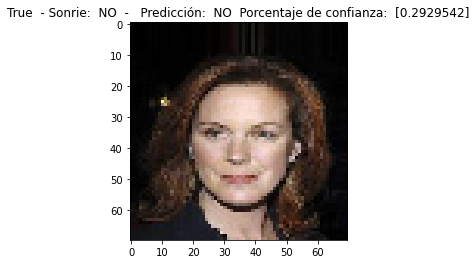

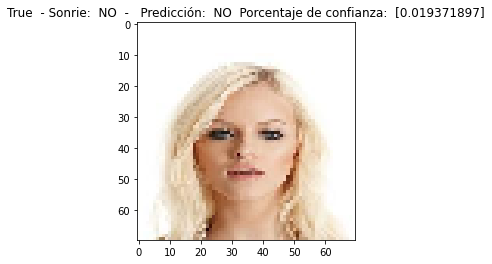

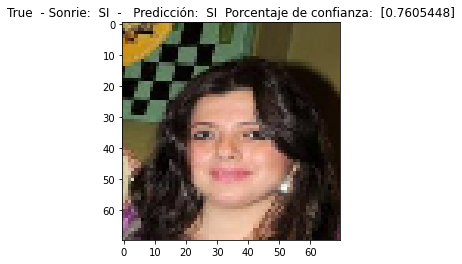

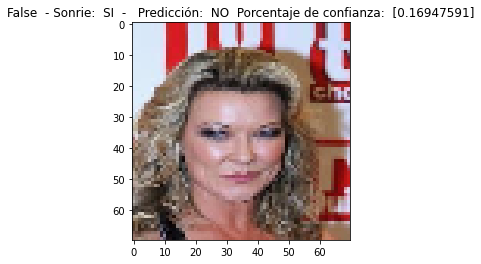

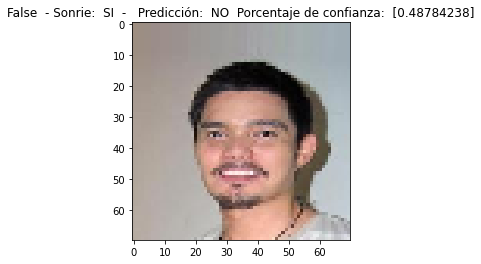

In [42]:
prediccion(mlp_model,test_generator)

### Conclusiones MPN

Los resultados obtenidos en la métrica accuracy son muy buenos. Logrando durante el entrenamiento un máximo en train de 0.8923 y en test de 0.8987. 

Al ver los resultados esperaríamos que el modelo sea capaz de predecir correctamente  si una persona está o no sonriendo. Sin embargo, en este caso los resultados no fueron tan buenos como los vistos en la CNN.

Como conclusión podemos decir que el modelo no es del todo confiable y capaz de predecir correctamente la clase a partir de los ejemplos.


### Conclusiones finales

Como conclusiones finales podemos decir que el modelo indicado para detectar si una persona está o no sonriendo es la red neuronal convolucional. A pesar de obtener buenos resultados con la red MLP construida, en la práctica vemos que no funcionó correctamente, falló en la predicción de algunos ejemplo mostrando porcentajes de confianza menores a los entregados por CNN.

Tal como se habló en clases, para este tipo de problemas (clasificación de imágenes), las redes convolucionales se comportan mejor, son más efectivas. 